**Necessary Libraries**

In [25]:
!pip install nltk

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize
import plotly.express as px
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

**Reading Datasets from CSV files**

In [27]:
df1=pd.read_csv('/content/drive/MyDrive/Reddit_Data.csv')
df2=pd.read_csv('/content/drive/MyDrive/Twitter_Data.csv')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Datasets Information And Data Cleaning**

In [28]:
df1

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [29]:
df2

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [31]:
df1.columns=['text','labels']
df2.columns=['text','labels']

In [32]:
df1.head()

,text,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [33]:
df2.head()

,text,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [34]:
#Merge Datasets
data = pd.concat([df1, df2], ignore_index = True)

In [35]:
data

,text,labels
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0
...,...,...
200224,why these 456 crores paid neerav modi not reco...,-1.0
200225,dear rss terrorist payal gawar what about modi...,-1.0
200226,did you cover her interaction forum where she ...,0.0
200227,there big project came into india modi dream p...,0.0


**Handling** **Missing** **Values**

In [36]:
data.isnull().sum()

,0
text,104
labels,7


In [37]:
data = data.dropna()

In [38]:
data.head()

,text,labels
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


**DataPreprocessing**

In [39]:
import re,string,nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer

In [40]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)
    #removing alphanumeric characters eg-XYZ123ABC
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#removing all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [103]:
def data_processing(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text=stemming(text)
    text=lemmatization(text)
    return text

In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
data['text1']=data['text'].apply(data_processing)

<ipython-input-49-be84ffbfde11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text1']=data['text'].apply(data_processing)


In [50]:
data['text1']

,text1
0,family mormon never try explain still stare pu...
1,buddhism much lot compatible christianity espe...
2,seriously say thing first get complex explain ...
3,learn want teach different focus goal wrap pap...
4,benefit may want read live buddha live christ ...
...,...
200224,crores pay neerav modi recover congress leader...
200225,dear rss terrorist payal gawar modi kill plus ...
200226,cover interaction forum leave
200227,big project come india modi dream project happ...


In [51]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [52]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    # Get sentiment scores using VADER
    scores = sid.polarity_scores(text)
    # Extract compound score, which represents overall sentiment
    compound_score = scores['compound']
    # Return compound score
    return compound_score

# Apply sentiment analysis to the cleaned text data
data['sentiment_score'] = data['text1'].apply(get_sentiment_scores)

<ipython-input-52-8849dbdab1eb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment_score'] = data['text1'].apply(get_sentiment_scores)


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 200228
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   text             200118 non-null  object 
 1   labels           200118 non-null  float64
 2   text1            200118 non-null  object 
 3   sentiment_score  200118 non-null  float64
dtypes: float64(2), object(2)
memory usage: 7.6+ MB


In [55]:
data.drop('text', axis=1, inplace=True)

<ipython-input-55-e0d70d154b07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('text', axis=1, inplace=True)


In [56]:
data.head()

,labels,text1,sentiment_score
0,1.0,family mormon never try explain still stare pu...,0.9423
1,1.0,buddhism much lot compatible christianity espe...,0.9831
2,-1.0,seriously say thing first get complex explain ...,0.7430
3,0.0,learn want teach different focus goal wrap pap...,0.0772
4,1.0,benefit may want read live buddha live christ ...,0.9393


In [57]:
data['label'] = data['labels'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

<ipython-input-57-95b0dc3750cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['labels'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})


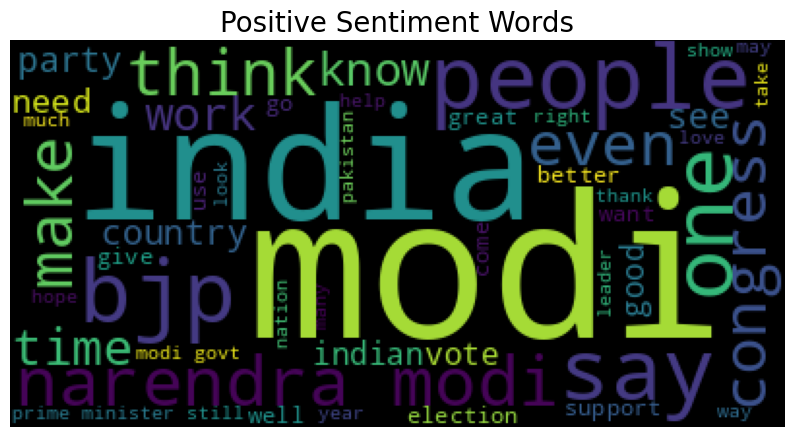

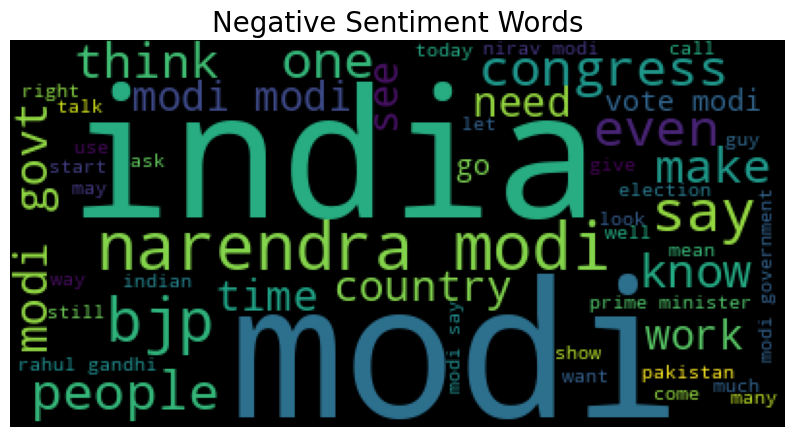

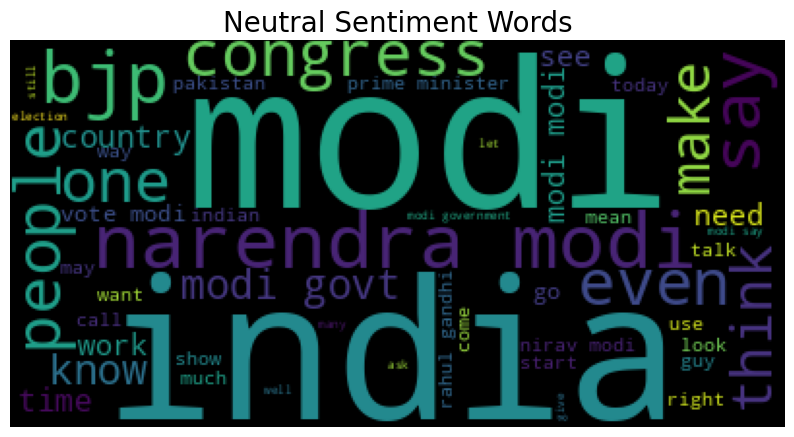

In [58]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def wordcount_gen(df, category, sentiment_column='sentiment_score'):
              """
              Generating Word Cloud

              Inputs:
                - df: DataFrame containing the data
                - category: Positive/Negative/Neutral
                - sentiment_column (optional): Name of the column containing sentiment score (default: 'sentiment_score')
              """

              # Filter data based on sentiment
              filtered_data = df[df[sentiment_column] > 0.5] if category == 'Positive' else df[df[sentiment_column] <= 0.5]

              # Combine all messages from the filtered data
              combined_tweets = " ".join(filtered_data['text1'])

              # Initialize wordcloud object
              wc = WordCloud(background_color='black',
                              max_words=50,
                              stopwords=STOPWORDS)

              # Generate and plot wordcloud
              plt.figure(figsize=(10, 10))
              plt.imshow(wc.generate(combined_tweets))
              plt.title('{} Sentiment Words'.format(category), fontsize=20)
              plt.axis('off')
              plt.show()
#Positive tweet words
wordcount_gen(data, 'Positive')

# Negative tweet words
wordcount_gen(data, 'Negative')

# Neutral tweet words (assuming sentiment_column < 0.5 is neutral)
wordcount_gen(data, 'Neutral')

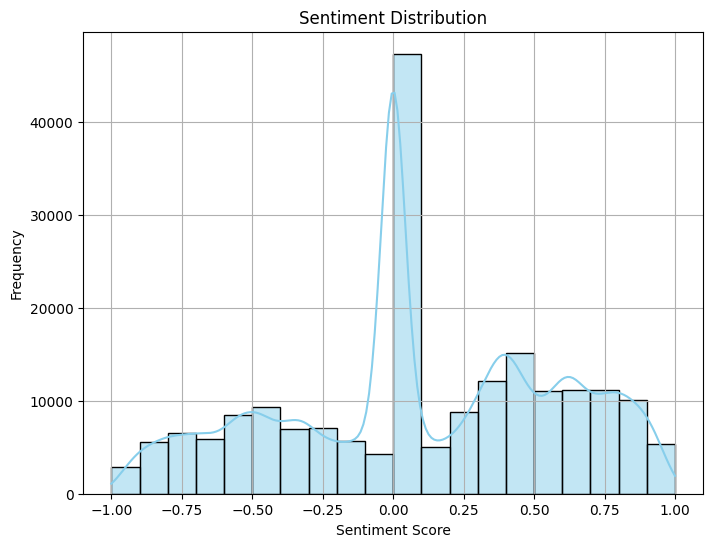

In [59]:
plt.figure(figsize=(8, 6))
sns.histplot(data['sentiment_score'], bins=20, kde=True, color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

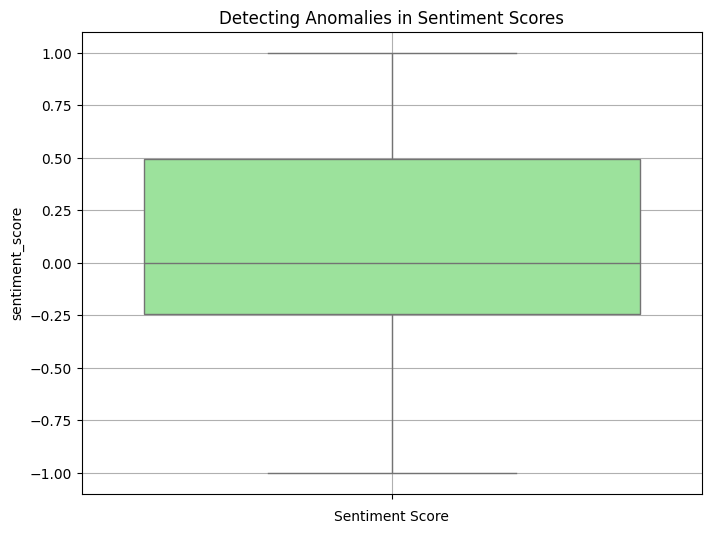

In [60]:
plt.figure(figsize=(8, 6))
sns.boxplot(data['sentiment_score'], color='lightgreen')
plt.title('Detecting Anomalies in Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.grid(True)
plt.show()

In [61]:
data.head(20)

,labels,text1,sentiment_score,label
0,1.0,family mormon never try explain still stare pu...,0.9423,Positive
1,1.0,buddhism much lot compatible christianity espe...,0.9831,Positive
2,-1.0,seriously say thing first get complex explain ...,0.7430,Negative
3,0.0,learn want teach different focus goal wrap pap...,0.0772,Neutral
4,1.0,benefit may want read live buddha live christ ...,0.9393,Positive
5,-1.0,sit together watch simpsons episode lisa becom...,0.3626,Negative
6,1.0,teens discover zen meditation undiagnosed bpd ...,0.9842,Positive
7,0.0,jesus zen meet jew,0.0000,Neutral
8,-1.0,two varieties christians dogmatic dwell word c...,0.6249,Negative
9,1.0,dont worry try explain meditate regularly try ...,0.6131,Positive


<Axes: xlabel='label', ylabel='count'>

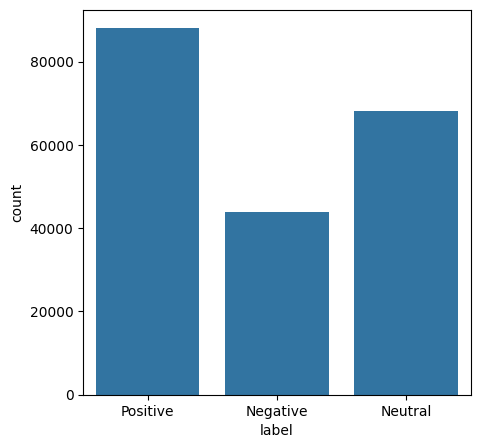

In [63]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = data)

Text(0.5, 1.0, 'Distribution of sentiments')

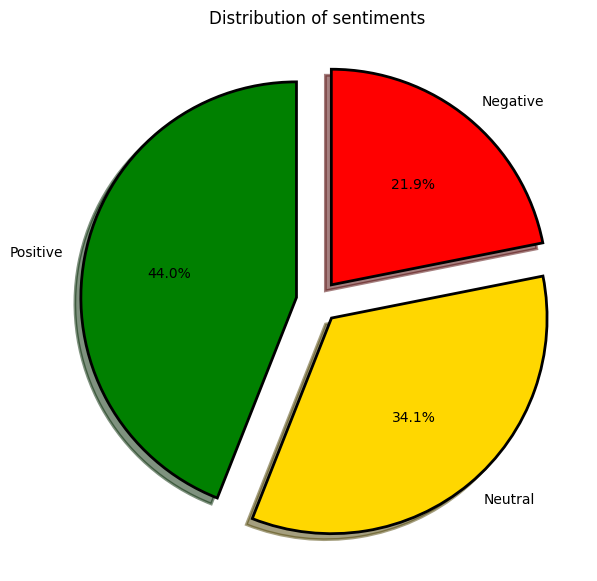

In [64]:
fig = plt.figure(figsize=(7,7))
colors = ("green", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data['label'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

**Train And Test Split**

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report





In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200118 entries, 0 to 200228
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   labels           200118 non-null  float64
 1   text1            200118 non-null  object 
 2   sentiment_score  200118 non-null  float64
 3   label            200118 non-null  object 
dtypes: float64(2), object(2)
memory usage: 7.6+ MB


In [67]:
X=data['text1']
Y=data['labels']

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [70]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the testing data
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [71]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (160094,)
Size of y_train: (160094,)
Size of x_test: (40024,)
Size of y_test: (40024,)


In [72]:
print(f"x_train shape: {x_train.shape}")  # Expected: (30487, number_of_features)
print(f"y_train shape: {y_train.shape}")

x_train shape: (160094,)
y_train shape: (160094,)


**Model Building**

In [75]:
logreg = LogisticRegression()
logreg.fit(x_train_tfidf, y_train)
logreg_pred = logreg.predict(x_test_tfidf)
logreg_acc = accuracy_score(logreg_pred, y_test)
print(" Logistic Test accuracy: {:.2f}%".format(logreg_acc*100))

 Logistic Test accuracy: 86.49%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 6561  1071  1228]
 [  292 12706   529]
 [  830  1458 15349]]


              precision    recall  f1-score   support

    Negative       0.85      0.74      0.79      8860
     Neutral       0.83      0.94      0.88     13527
    Positive       0.90      0.87      0.88     17637

    accuracy                           0.86     40024
   macro avg       0.86      0.85      0.85     40024
weighted avg       0.87      0.86      0.86     40024



[[ 6561  1071  1228]
 [  292 12706   529]
 [  830  1458 15349]]


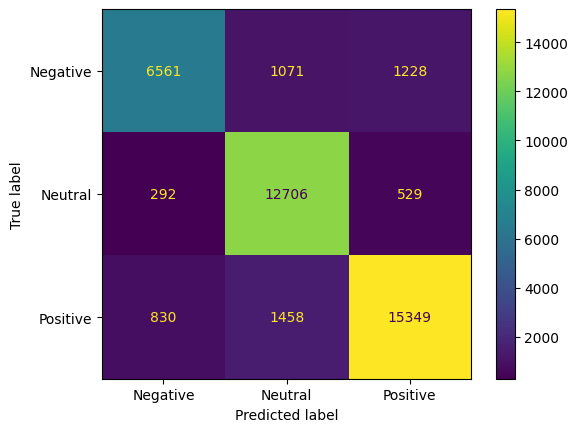

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, logreg_pred)
print(confusion_matrix(y_test, logreg_pred))

In [79]:
#saving logistic model
pickle.dump(logreg, open('logreg.pkl', 'wb'))

In [80]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train_tfidf, y_train)

LinearSVC()

In [82]:
svc_pred = SVCmodel.predict(x_test_tfidf)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 87.61%


In [83]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 6840   859  1161]
 [  316 12698   513]
 [  847  1264 15526]]


              precision    recall  f1-score   support

    Negative       0.85      0.77      0.81      8860
     Neutral       0.86      0.94      0.90     13527
    Positive       0.90      0.88      0.89     17637

    accuracy                           0.88     40024
   macro avg       0.87      0.86      0.87     40024
weighted avg       0.88      0.88      0.88     40024



[[ 6840   859  1161]
 [  316 12698   513]
 [  847  1264 15526]]


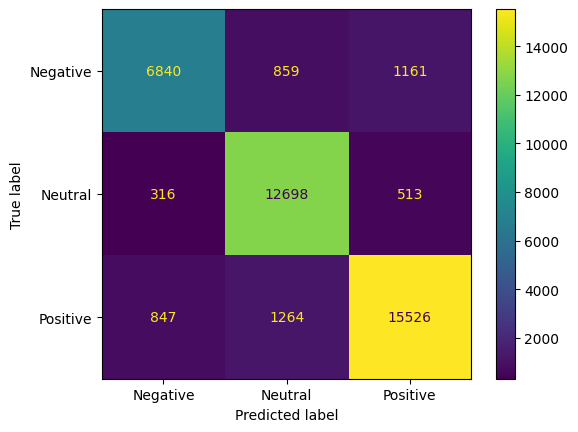

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, svc_pred)
print(confusion_matrix(y_test, svc_pred))

In [85]:
#saving SVC model
pickle.dump(SVCmodel, open('SVCmodel.pkl', 'wb'))

In [87]:
svm_mnb = MultinomialNB()
svm_mnb.fit(x_train_tfidf, y_train)
mnb_prediction = svm_mnb.predict(x_test_tfidf)
mnb_acc= accuracy_score(mnb_prediction,y_test)
print("test accuracy: {:.2f}%".format(mnb_acc*100))

test accuracy: 56.62%


In [88]:
print(confusion_matrix(y_test, mnb_prediction))
print("\n")
print(classification_report(y_test, mnb_prediction))

[[ 1016   376  7468]
 [   46  4443  9038]
 [   29   404 17204]]


              precision    recall  f1-score   support

    Negative       0.93      0.11      0.20      8860
     Neutral       0.85      0.33      0.47     13527
    Positive       0.51      0.98      0.67     17637

    accuracy                           0.57     40024
   macro avg       0.76      0.47      0.45     40024
weighted avg       0.72      0.57      0.50     40024



[[ 1016   376  7468]
 [   46  4443  9038]
 [   29   404 17204]]


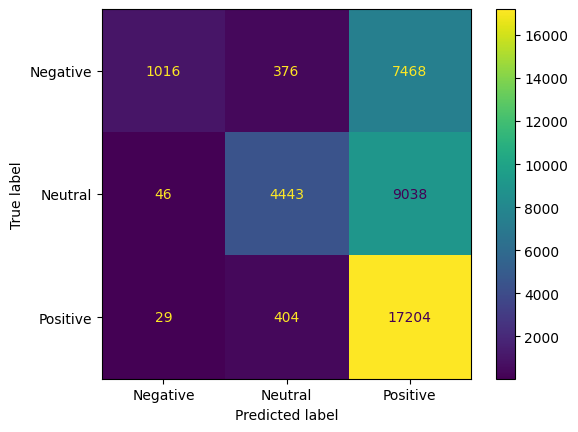

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, mnb_prediction)
print(confusion_matrix(y_test, mnb_prediction))

In [90]:
#saving Naive bayes classifier
pickle.dump(svm_mnb, open('svm_mnb.pkl', 'wb'))

In [141]:

logreg_acc = 0.88
svc_acc = 0.91
mnb_acc = 0.61

# Creating the dataframe
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'LinearSVC', 'MultinomialNB'],
    'Score': [100*round(logreg_acc, 4), 100*round(svc_acc, 4), 100*round(mnb_acc, 4)]
})

# Display the dataframe
print(models)



                 Model  Score
0  Logistic Regression   88.0
1            LinearSVC   91.0
2        MultinomialNB   61.0


In [142]:
models.sort_values(by='Score', ascending=True)

,Model,Score
2,MultinomialNB,61.0
0,Logistic Regression,88.0
1,LinearSVC,91.0


In [91]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training labels and transform them
y_train = le.fit_transform(y_train)

In [128]:
def predict_sentiment(custom_text, model, vectorizer):
    # Ensure that the input text is not None
    if custom_text is None or custom_text == "":
        raise ValueError("Input text cannot be None or empty")

    # Transform the input text using the TF-IDF vectorizer
    custom_text_transformed = vectorizer.transform([custom_text])

    # Predict sentiment
    prediction = model.predict(custom_text_transformed)
    return prediction[0]

# Example Usage
custom_text = " I feel terrible"  # Make sure custom_text is a valid string
try:
    predicted_sentiment = predict_sentiment(custom_text, logreg, tfidf_vectorizer)
    print(f"The sentiment is: {predicted_sentiment}")
except ValueError as e:
    print(e)

The sentiment is: Negative
